In [2]:
%matplotlib inline

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

from dataset import digits_2d
import model

tfb = tfp.bijectors
tfd = tfp.distributions

# Dataset

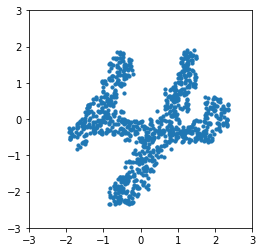

In [3]:
def sample_plot(samples, ax=None, c=None, alpha=None):
    no_ax = (ax is None)
    if no_ax:
        fig, ax = plt.subplots(1, 1)
        fig.set_figheight(4)
        fig.set_figwidth(4)
    ax.scatter(*(samples.T), s=10, c=c, alpha=alpha)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
    if no_ax:
        plt.show()

samples = np.array(
    list(digits_2d.Digits2D('./assets/digits.png', length=1000).generate()))
sample_plot(samples)

# Flow

In [4]:
flow = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=[0, 0], scale_diag=[1, 1]),
    bijector=model.RealNVP(n_layers=5, n_masked=1, n_units=2)
)

# Training

Instructions for updating:
Please use `layer.__call__` method instead.
iteration: 100


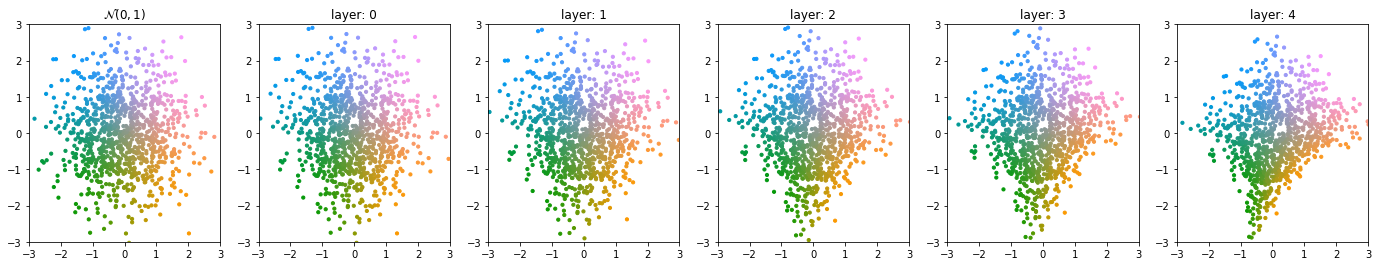

iteration: 200


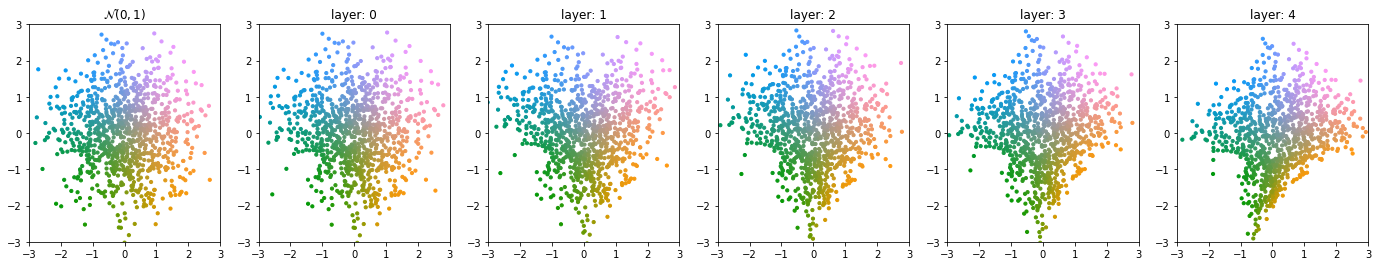

iteration: 300


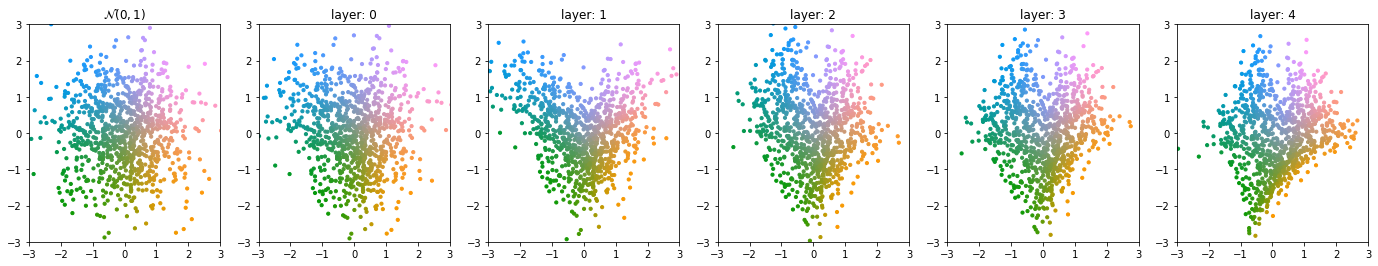

iteration: 400


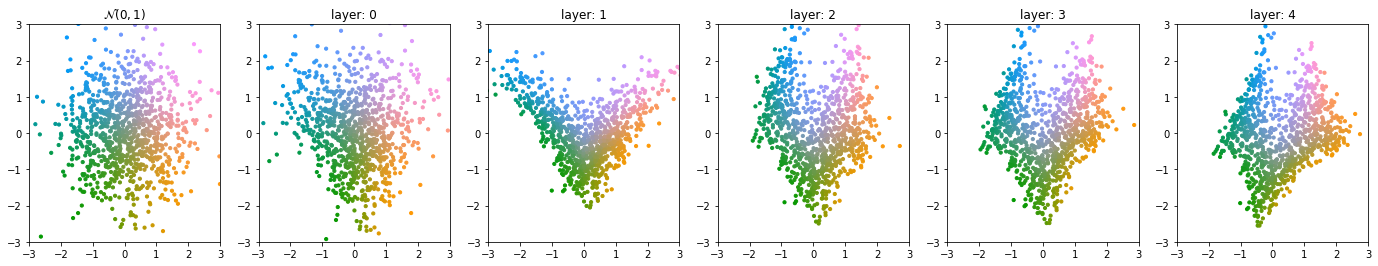

iteration: 500


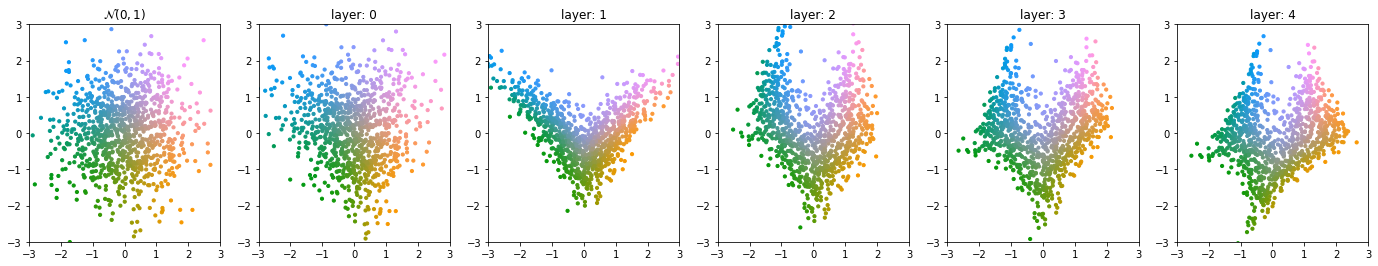

iteration: 600


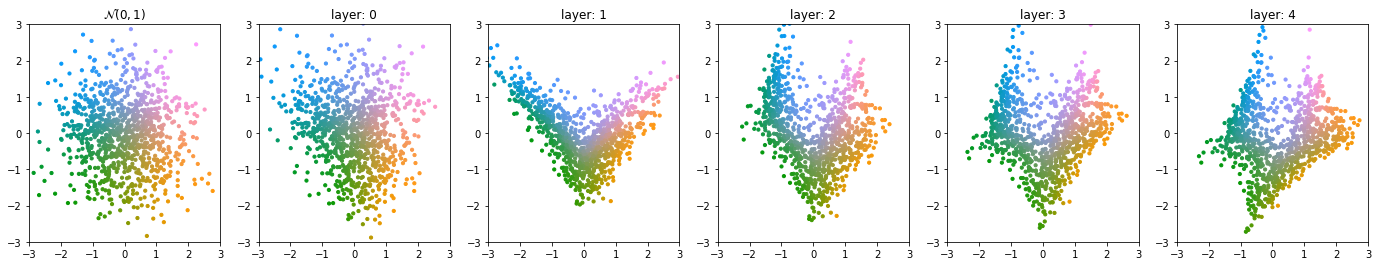

iteration: 700


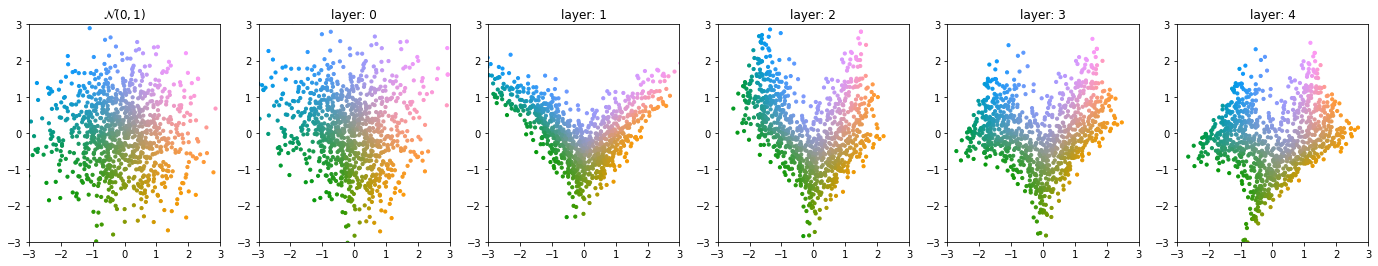

iteration: 800


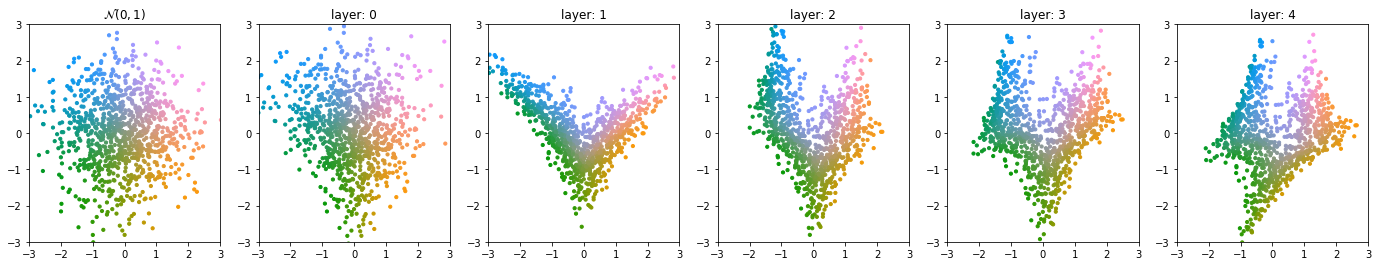

iteration: 900


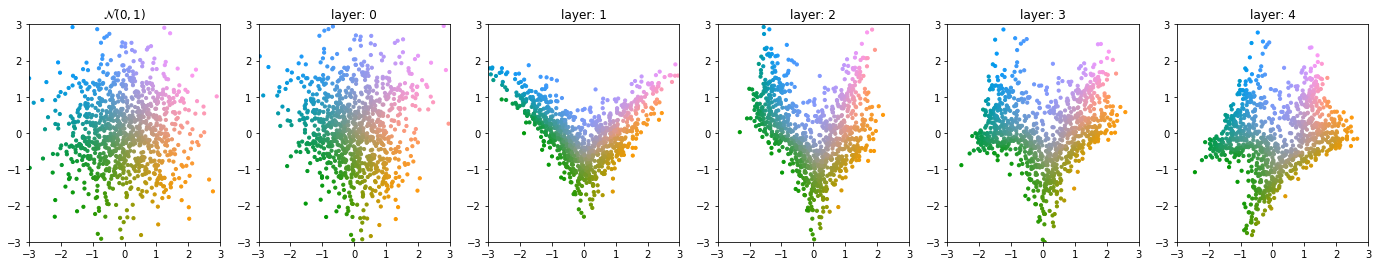

iteration: 1000


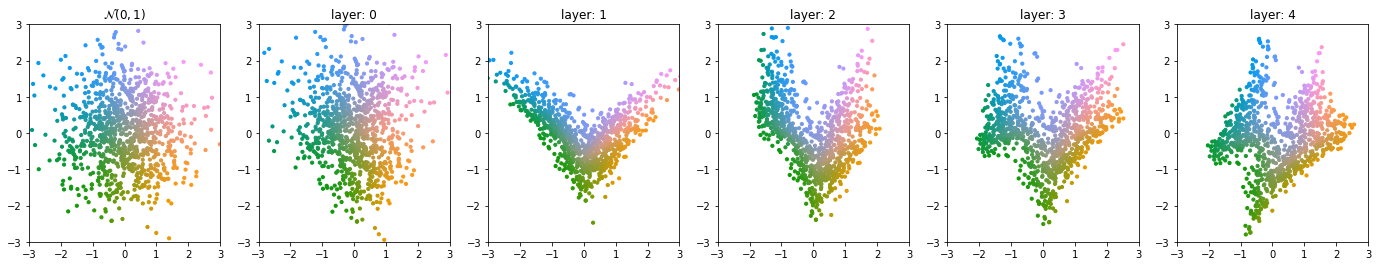

iteration: 1100


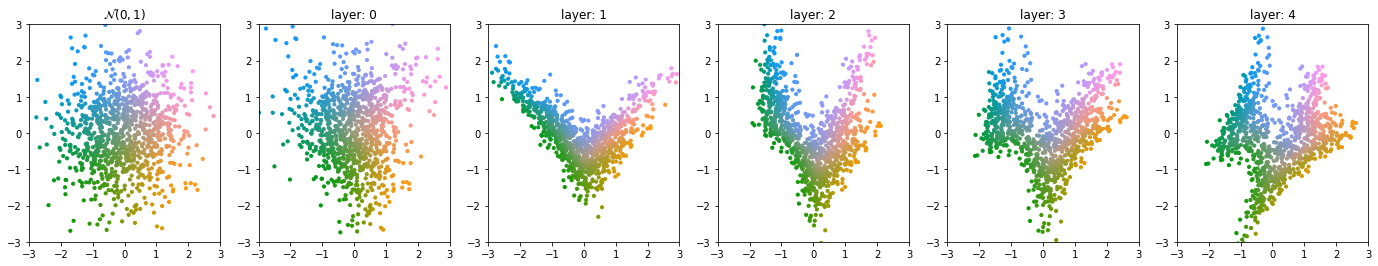

iteration: 1200


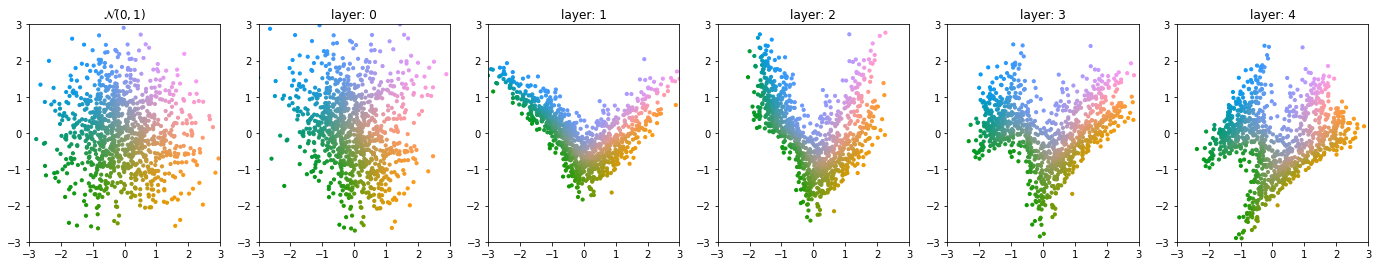

iteration: 1300


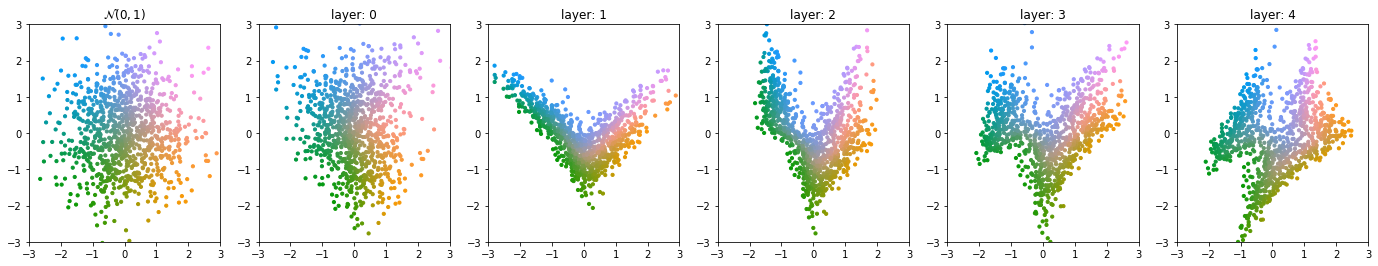

iteration: 1400


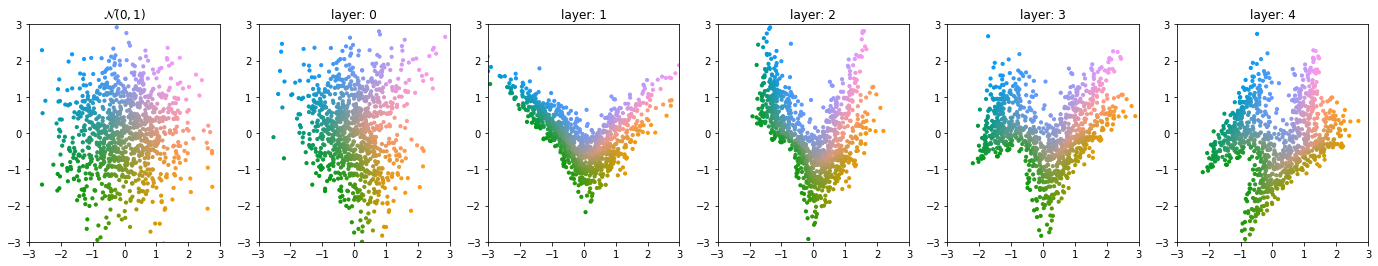

iteration: 1500


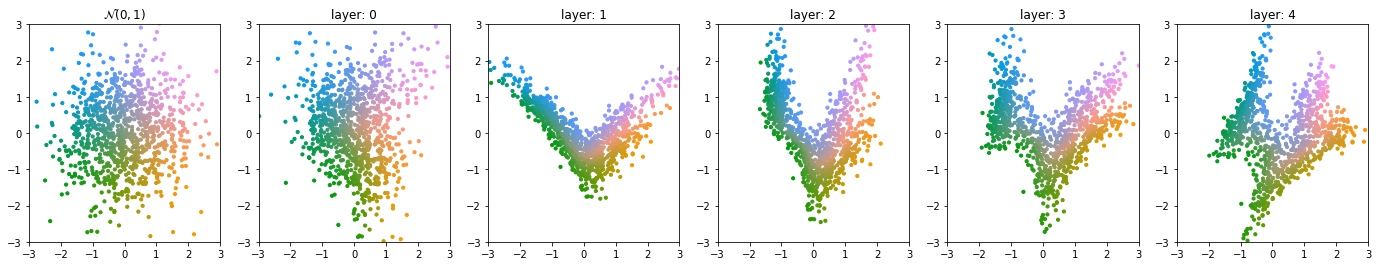

iteration: 1600


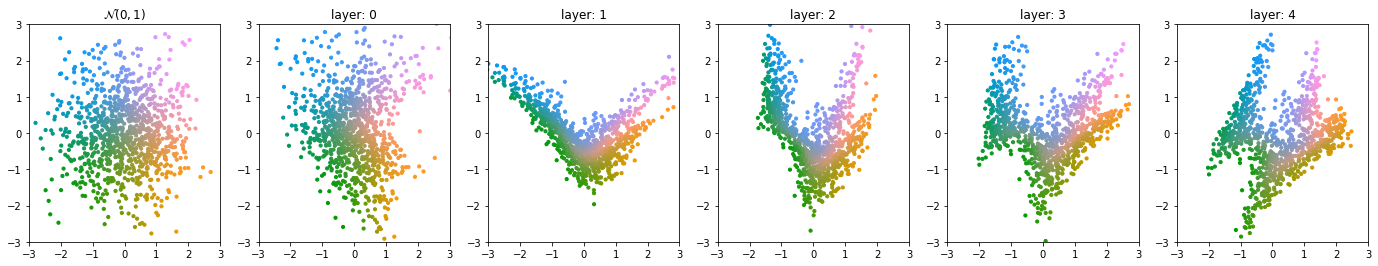

iteration: 1700


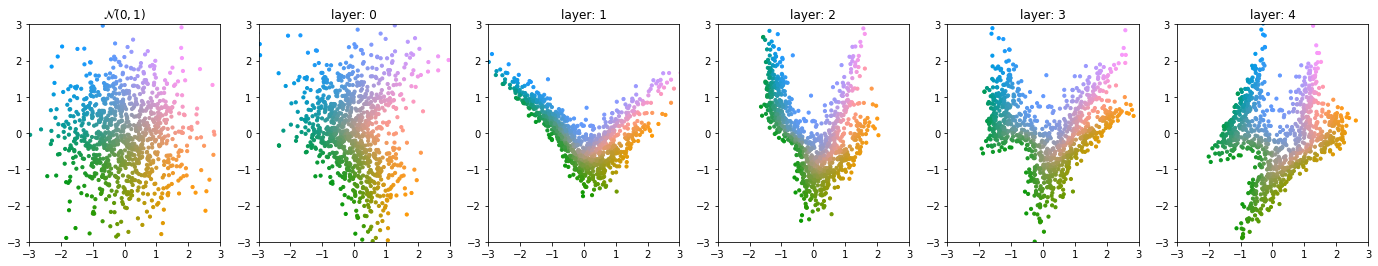

iteration: 1800


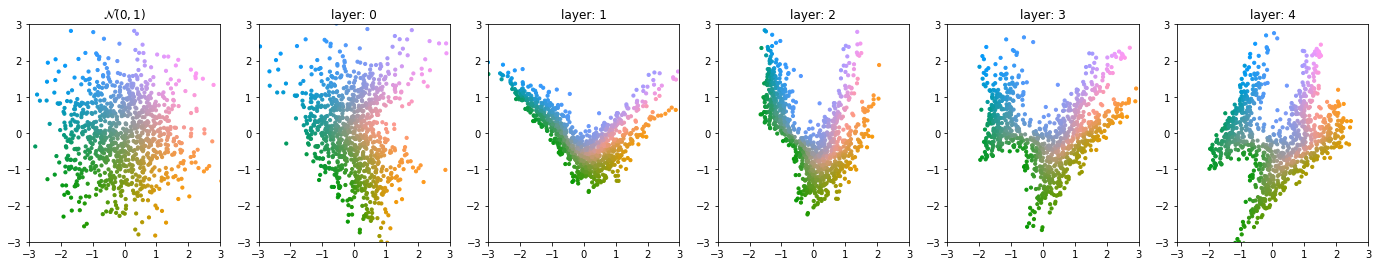

iteration: 1900


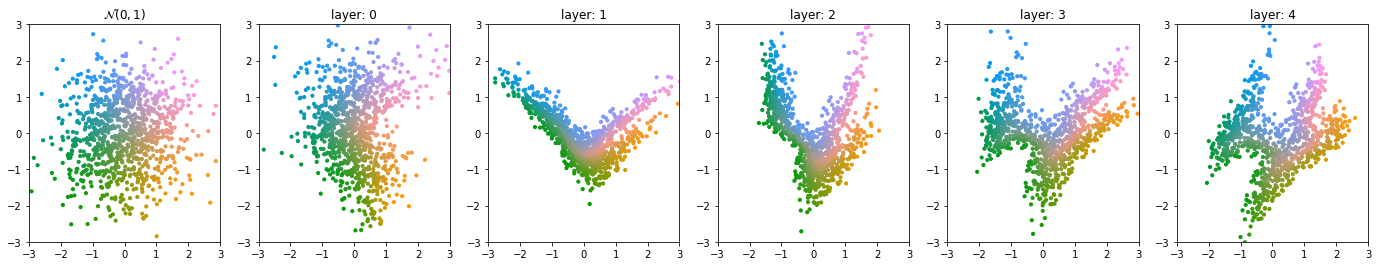

iteration: 2000


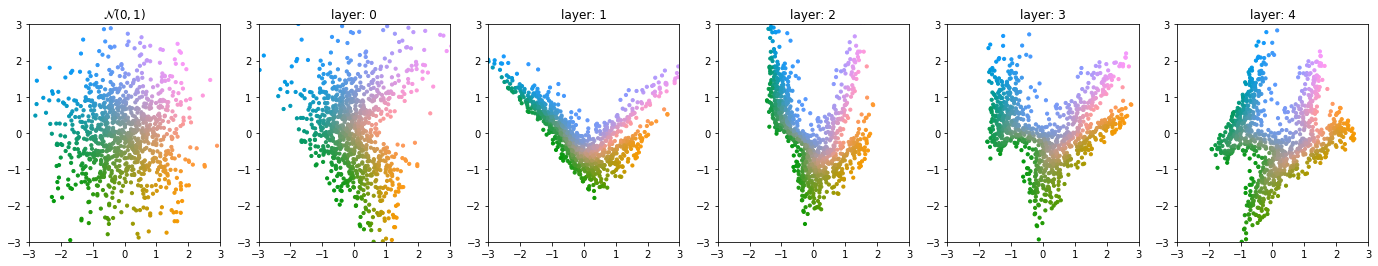

iteration: 2100


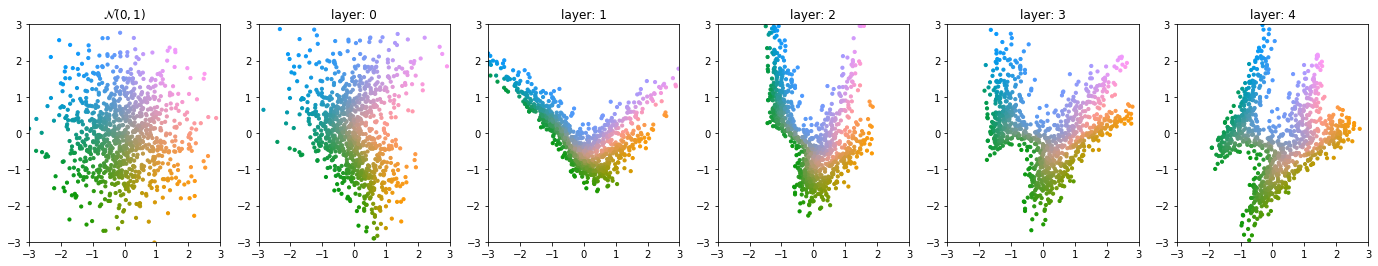

iteration: 2200


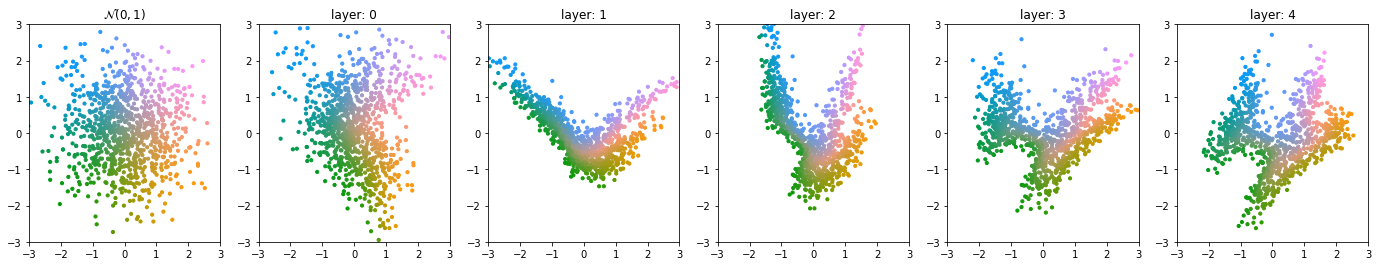

iteration: 2300


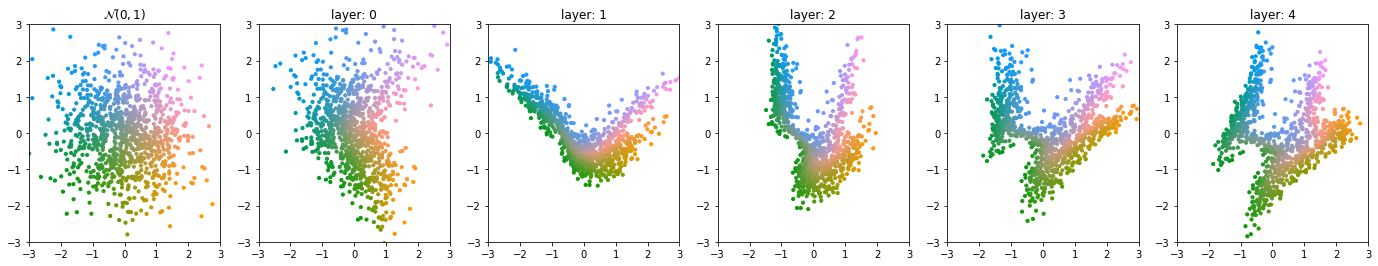

iteration: 2400


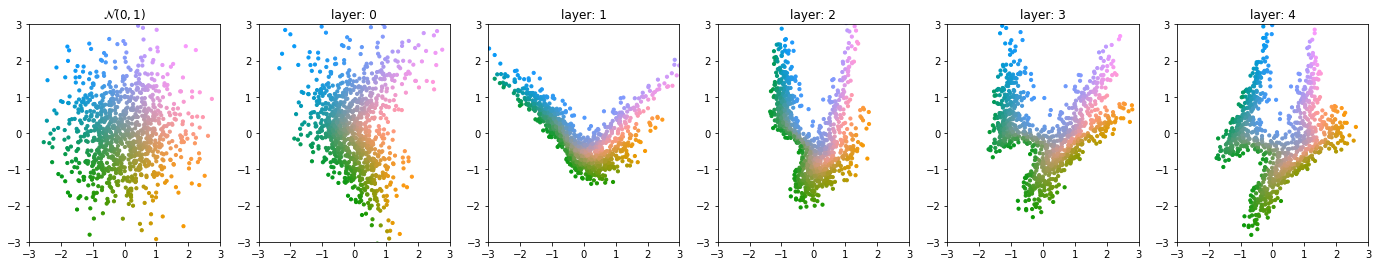

iteration: 2500


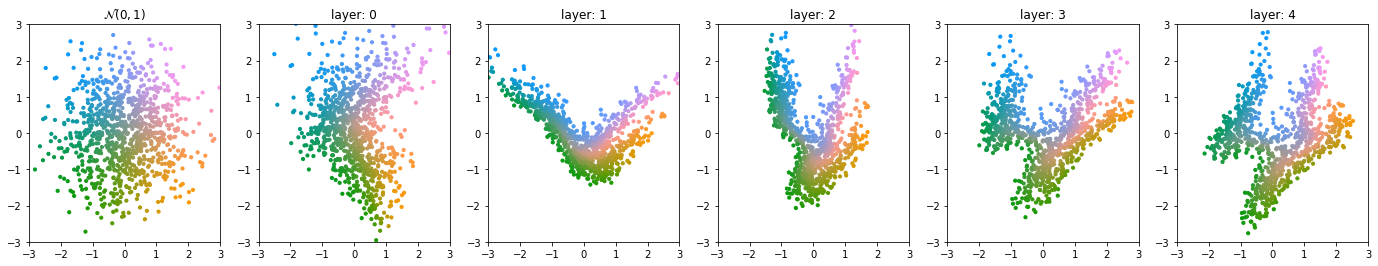

In [5]:
@tf.function
def negative_log_likelihood(log_prob):
    return -tf.reduce_mean(log_prob)

def train(batch, flow, optimizer, avg_loss):
    with tf.GradientTape() as tape:
        log_prob = flow.log_prob(batch)
        loss = negative_log_likelihood(log_prob)

    grads = tape.gradient(loss, flow.trainable_variables)

    optimizer.apply_gradients(zip(grads, flow.trainable_variables))

    avg_loss.update_state(loss)
    
    iterations = optimizer.iterations
    if iterations % 10 == 0:
        tf.summary.scalar(
            'loss', avg_loss.result(),
            step=optimizer.iterations
        )
        avg_loss.reset_states()

def plot_example(flow, n_samples):
    n_plots = len(flow.bijector.bijectors) + 1
    fig = plt.figure(figsize=(4*n_plots, 4))

    samples = flow.distribution.sample(1000)
    rgb = np.stack((
        samples.numpy()[:, 0].argsort().argsort() / len(samples),
        np.ones(len(samples)) * 0.6,
        samples.numpy()[:, 1].argsort().argsort() / len(samples),
    ), axis=1)
    
    ax = fig.add_subplot(1, n_plots, 1)
    ax.set_title('$\mathcal{N}(0, 1)$')
    sample_plot(samples.numpy(), ax=ax, c=rgb)

    
    for i, b in enumerate(reversed(flow.bijector.bijectors)):
        samples = b.forward(samples)
        ax = fig.add_subplot(1, n_plots, 2+i)
        ax.set_title(f'layer: {i}')
        sample_plot(samples.numpy(), ax=ax, c=rgb)

    plt.show()
        
optimizer = tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

# summary writer
writer = tf.summary.create_file_writer('logs')

dataset = digits_2d.get_dataset('./assets/digits.png', length=320000)
for batch in dataset.batch(128).prefetch(8):
    with writer.as_default():
        train(batch, flow, optimizer, avg_loss)

    if optimizer.iterations % 100 == 0:
        print(f'iteration: {optimizer.iterations.numpy()}')
        plot_example(flow, 1000)